In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from dataclasses import dataclass

In [37]:
def debug_save(img, path):
    cv2.imwrite(f"debug/{path}.png", img)


def normalize_line(line) -> None:
    line = line[0]

    if line[0] < 0:
        line[0] *= -1
        line[1] += np.pi


def are_duplicates(line_a, line_b, rho_threshold, theta_threshold):
    rho_a, theta_a = line_a[0]
    rho_b, theta_b = line_b[0]

    if rho_a < 0:
        rho_a = -rho_a
        theta_a += np.pi

    if rho_b < 0:
        rho_b = -rho_b
        theta_b += np.pi

    rho_diff = (theta_a - theta_b + np.pi) % (2 * np.pi) - np.pi

    if abs(rho_diff) < theta_threshold and abs(rho_a - rho_b) < rho_threshold:
        return True
    else:
        return False


def is_axis_aligned(line, threshold):
    rho, theta = line[0]

    if 0 <= theta <= threshold or np.pi - threshold <= theta <= np.pi or np.pi/2 - threshold <= theta <= np.pi/2 + threshold:
        return True
    else:
        return False


def auto_canny(image, sigma=0.33):
    #bluring the image
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    # return the edged image
    return edged


def is_horizontal(line, threshold):
    rho, theta = line[0]

    if np.pi/2 - threshold <= theta % np.pi <= np.pi/2 + threshold:
        return True
    else:
        return False


def is_vertical(line, threshold):
    rho, theta = line[0]

    if 0 <= theta <= threshold or np.pi - threshold <= theta % np.pi <= np.pi:
        return True
    else:
        return False


def simplify_image(img, limit, grid, iters):
        """Simplify image using CLAHE algorithm (adaptive histogram
        equalization)."""
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # img = cv2.bilateralFilter(img, 7, 50, 50)
        # img = cv2.medianBlur(img, 5)
        # img = cv2.GaussianBlur(img, (5, 5), 1)

        for _ in range(iters):
            img = cv2.createCLAHE(clipLimit=limit, tileGridSize=grid).apply(
                img)
        debug_save(img, "slid_clahe_@1")
        if limit != 0:
            kernel = np.ones((10, 10), np.uint8)
            img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
            debug_save(img, "slid_clahe_@2")
        return img


def find_edges(img):
    edges = auto_canny(img)
    # edges = cv2.GaussianBlur(edges, (5, 5), 2)
    return edges


def find_lines(edges: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    lines = cv2.HoughLines(edges, rho = 1,theta = 1*np.pi/180,threshold = 30)
    if lines is None:
        return np.zeros([0, 1, 2]), np.zeros([0, 1, 2])
    lines = lines[:50]

    for line in lines:
        normalize_line(line)

    lines = np.array([
        line for index, line in enumerate(lines) if
        all([not are_duplicates(x, line, 10, 5*np.pi/180) for x in lines[:index]])
    ])

    h_lines = np.array([line for line in lines if is_horizontal(line, 15*np.pi/180)])
    v_lines = np.array([line for line in lines if is_vertical(line, 15*np.pi/180)])

    return h_lines, v_lines


def overlay_lines(img, lines, color):
    img = img.copy()

    for line in lines:
        rho,theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(img, (x1,y1), (x2,y2), color, 1)

    return img

In [33]:
def intersection(line1, line2):

    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]

    # if lines are almost parallel, we skip them
    if abs(theta1 - theta2) < 0.001:
        return None

    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [x0, y0]


def are_intersecting_in_range(line1, line2, xy_min, xy_max):
    intersect = intersection(line1, line2)
    if intersect is None:
        return False

    return xy_min[0] < intersect[0] < xy_max[0] and xy_min[1] < intersect[1] < xy_max[1]


def segmented_intersections(h_lines, v_lines):
    intersections = []
    for h_line in h_lines:
        for v_line in v_lines:
            # horizontal lines and vertical lines always intersect so no None check
            intersections.append(intersection(h_line, v_line))

    return intersections

def overlay_markers(img, points):
    img = img.copy()
    for x, y in points:
        cv2.drawMarker(img, (x, y), 20, thickness = 5)
    return img


In [34]:
import math

# dwie funkcje totalnie nie ukradzione ze stacka

def average_angles(angles):
    """Average (mean) of angles

    Return the average of an input sequence of angles. The result is between
    ``0`` and ``2 * math.pi``.
    If the average is not defined (e.g. ``average_angles([0, math.pi]))``,
    a ``ValueError`` is raised.
    """

    x = sum(math.cos(a) for a in angles)
    y = sum(math.sin(a) for a in angles)

    if x == 0 and y == 0:
        raise ValueError(
            "The angle average of the inputs is undefined: %r" % angles)

    # To get outputs from -pi to +pi, delete everything but math.atan2() here.
    return math.fmod(math.atan2(y, x) + 2 * math.pi, 2 * math.pi)


def subtract_angles(lhs, rhs):
    return math.fmod((lhs - rhs) + math.pi * 3, 2 * math.pi) - math.pi


# oboże kurwa ała, numpy array w liście jest jakiś niedojebany
def remove_intersecting_lines(lines):
    if lines.shape == 0 or lines.shape[0] == 0:
        return lines

    average_theta = average_angles([line[0][1] for line in lines])

    incorrect_lines_indexes = []

    for index, line in enumerate(lines):
        if index in incorrect_lines_indexes:
            continue

        intersecting_lines_indexes = [index]
        for other_line_index in range(index+1, len(lines)):
            other_line = lines[other_line_index]
            if are_intersecting_in_range(line, other_line, (-256, -256), (768, 768)):
                intersecting_lines_indexes.append(other_line_index)

        min_angle_diff = min([abs(subtract_angles(average_theta, lines[i][0][1])) for i in intersecting_lines_indexes])

        for i in intersecting_lines_indexes:
            if abs(subtract_angles(average_theta, lines[i][0][1])) > min_angle_diff:
                incorrect_lines_indexes.append(i)

    return [line for index, line in enumerate(lines) if index not in incorrect_lines_indexes]


In [85]:
def remove_suspiciously_narrow_lines(lines, center_position: int, are_vertical: bool, accespted_min_width: float = 0.8, accespted_max_width: float = 1.5):
    @dataclass()
    class NpArrayWrapper:
        value: np.array
        position: int = 0
        offset_from_prev: int = None
        offset_to_next: int = None

    # lines could be sorted by rho, but we need better distance metric anyway

    line_wrappers = [NpArrayWrapper(line) for line in lines]

    if len(line_wrappers) < 2:
        return lines

    for line_wrapper in line_wrappers:
        if are_vertical:
            line_wrapper.position = intersection(line_wrapper.value, [[center_position, np.pi/2]])[0]
        else:
            line_wrapper.position = intersection(line_wrapper.value, [[center_position, 0.0]])[1]

    line_wrappers = sorted(line_wrappers, key=lambda x: x.position)

    for index in range(1, len(line_wrappers)):
        line_wrappers[index].offset_from_prev = line_wrappers[index].position - line_wrappers[index - 1].position

    # marcin nie bij, ja wiem, że liczę dwa razy to samo
    for index in range(0, len(line_wrappers) - 1):
        line_wrappers[index].offset_to_next = line_wrappers[index + 1].position - line_wrappers[index].position

    average_gap = sum([line_wrapper.offset_from_prev for line_wrapper in line_wrappers[1:]]) / (len(line_wrappers) - 1)

    result_lines = []

    for line_wrapper in line_wrappers:
        if (line_wrapper.offset_from_prev and accespted_min_width < line_wrapper.offset_from_prev/average_gap < accespted_max_width)\
                or (line_wrapper.offset_to_next and accespted_min_width < line_wrapper.offset_to_next/average_gap < accespted_max_width):
            result_lines.append(line_wrapper.value)

    return np.array(result_lines)

In [86]:
def process_img(img):
    img = cv2.resize(img, (512, 512))
    overlayed_frame = img.copy()

    simplified_img = simplify_image(img, limit=3, grid=(2, 6), iters=5)

    edges = find_edges(simplified_img)
    h_lines, v_lines = find_lines(edges)

    h_lines = remove_intersecting_lines(h_lines)
    v_lines = remove_intersecting_lines(v_lines)

    h_lines = remove_suspiciously_narrow_lines(h_lines, 512//2, are_vertical=False, accespted_min_width=0.75, accespted_max_width=2.0)
    v_lines = remove_suspiciously_narrow_lines(v_lines, 512//2, are_vertical=True, accespted_min_width=0.75, accespted_max_width=2.0)

    intersections = np.array(segmented_intersections(h_lines, v_lines))

    overlayed_frame = overlay_lines(overlayed_frame, v_lines, (255, 0, 0))
    overlayed_frame = overlay_lines(overlayed_frame, h_lines, (0, 255, 0))
    overlayed_frame = overlay_markers(overlayed_frame, intersections)

    concatinated_images = np.concatenate([img, cv2.cvtColor(simplified_img, cv2.COLOR_GRAY2BGR), overlayed_frame], axis=1)

    return concatinated_images

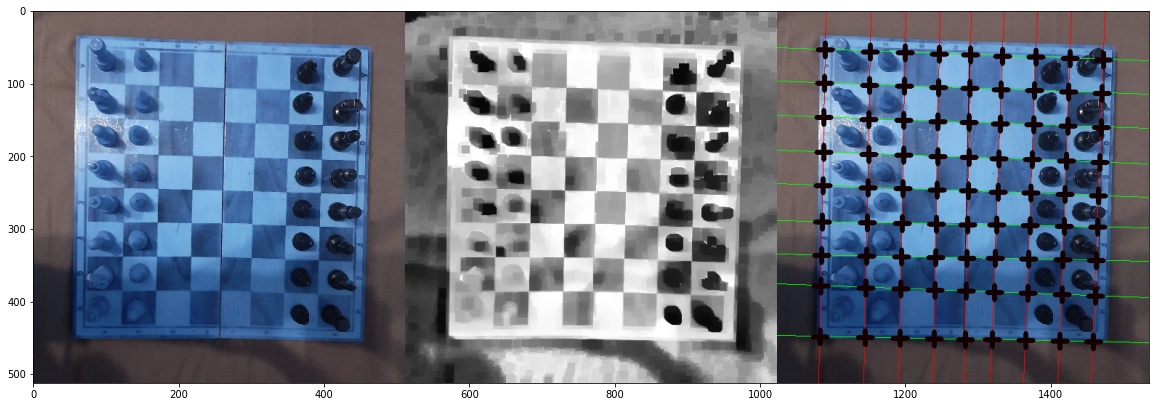

In [87]:
img = cv2.imread("test8.jpg", cv2.IMREAD_COLOR)

img = process_img(img)

plt.figure(figsize = (20, 30))
plt.imshow(img)
plt.show()

In [88]:
import cv2
import numpy as np


def process_samera_feed():
    # Create a VideoCapture object

    try:
        cap = cv2.VideoCapture(0)

        # Check if camera opened successfully
        if (cap.isOpened() == False):
            print("Unable to read camera feed")
            cap.release()
            return

        # Default resolutions of the frame are obtained.The default resolutions are system dependent.
        # We convert the resolutions from float to integer.
        frame_width = int(cap.get(3))
        frame_height = int(cap.get(4))
        frame_size = min([frame_width, frame_height])

        # Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
        # out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (512, 512))

        while True:
            ret, frame = cap.read()

            frame = frame[(frame_height - frame_size)//2 : frame_height - (frame_height - frame_size)//2, (frame_width - frame_size)//2 : frame_width - (frame_width - frame_size)//2]
            frame = process_img(frame)

            if ret == True:
                # out.write(frame)
                cv2.imshow('processed', frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            else:
                break
    finally:
        cap.release()
        # out.release()
        cv2.destroyAllWindows()


process_samera_feed()

In [77]:
# BEZUŻYTECZNY KAWAŁEK ZIEMNIAKA

# def mask_largest_contour(img):
#     img = img.copy()
#     blur = cv2.GaussianBlur(img, (11,11), 0)
#
#     thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 5, 2)
#     # thresh = cv2.dilate(thresh, np.ones([3, 3]), iterations=2)
#     # thresh = cv2.erode(thresh, np.ones([3, 3]), iterations=2)
#
#     # contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#
#     plt.figure(figsize = (10,10))
#     plt.imshow(thresh)
#     plt.show()
#
#     # contour = max(contours, key=cv2.contourArea)
#
#     mask = np.zeros_like(img)
#     # cv2.drawContours(mask, [contour], 0, color=255, thickness=-1)
#     # cv2.drawContours(mask, [contour], 0, color=0, thickness=2)
#
#     rect = cv2.minAreaRect(cv2.findNonZero(thresh))
#     box = cv2.boxPoints(rect)
#     box = np.int0(box)
#     cv2.drawContours(mask,[box],0, 255,-1)
#
#     return mask
#
#
#
# img = cv2.imread("test8.jpg", cv2.IMREAD_COLOR)
# img = cv2.resize(img, (512, 512))
# original_img = img.copy()
#
# img = simplify_image(img, limit=3, grid=(3, 3), iters=5)
# mask = mask_largest_contour(img)
#
# plt.figure(figsize = (10,10))
# plt.imshow(original_img & cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR))
# plt.show()
#
# plt.figure(figsize = (10,10))
# plt.imshow(mask)
# plt.show()